# Description
In this project, we use the data from kaggle competition [Toxic Comment Classification Challenge by Jigsaw](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data?select=train.csv.zip) and only use the training data. Then we have break this raw training data into train and test data and evaluate the model performances in test data.

The dataset is taken from wikipedia edit text and is classified as one of the following:

1. toxic
2. severe_toxic
3. obscene
4. threat
5. insult
6. identity_hate

This is a multi-label (not-multiclass) classification. One text row has six labels and exactly one label is 1 and other labels are 0.


References:


# Load the Libraries

In [1]:
import os
import sys
import time

time_start_notebook = time.time()

In [2]:
%tensorflow_version 1.x

# bert server needs tf 1.x

TensorFlow 1.x selected.


In [3]:
%%capture
import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install watermark
    !pip install scikit-plot
    !pip install lrcurve

    #!pip install tensorflow-addons[tensorflow] # addons need tensorflow > 2

    !pip install bert-serving-client
    !pip install -U bert-serving-server[http]

In [4]:
# data science
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
sns.set(color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# mixed
import os
import time
import random
import subprocess
import joblib
from tqdm import tqdm, trange
from pprint import pprint

# random state
SEED=100
np.random.seed(SEED)

# machine learning
import sklearn

# deep learning
import tensorflow as tf
# import tensorflow_addons as tfa # tfa needs tensorflow > 2
from keras import backend as K
import lrcurve

# model eval
import scikitplot as skplt

# versions
import watermark
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2020-12-05 

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


sklearn    0.22.2.post1
pandas     1.1.4
matplotlib 3.2.2
joblib     0.17.0
watermark  2.0.2
scikitplot 0.3.7
tensorflow 1.15.2
numpy      1.18.5
seaborn    0.11.0



Using TensorFlow backend.


# Useful Functions

In [5]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

# GPU Testing

In [6]:
!nvidia-smi

Sat Dec  5 03:08:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W /  70W |   1311MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Training Data

In [7]:
%%capture

download_train_test = False

if download_train_test:
    !wget https://github.com/bhishanpdl/Datasets/blob/master/Projects/Jigsaw_Toxic_Comment_Classification/train.csv.zip?raw=true
    !unzip train.csv.zip?raw=true

    !wget https://github.com/bhishanpdl/Datasets/blob/master/Projects/Jigsaw_Toxic_Comment_Classification/test.csv.zip?raw=true
    !unzip test.csv.zip?raw=true

In [8]:
os.listdir()

['.config',
 'tmpSFdqY6',
 'out.file',
 'uncased_L-12_H-768_A-12',
 'train.csv',
 'tmpnRuMAo',
 'tmpwNQgfx',
 'x_train.npz',
 'tmp2dX35X',
 'test.csv.zip?raw=true',
 'tmpciV4sx',
 'uncased_L-12_H-768_A-12.zip',
 'x_test.npz',
 'test.csv',
 'tmpnMCIdP',
 'tmpNSYuIf',
 'tmp35folG',
 'tmpc7BNQf',
 'train.csv.zip?raw=true',
 'tmprZreQ6',
 'sample_data']

In [9]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,8d603d50affa1126,"""\nYes, aside, thank you for trying to answer ...",0,0,0,0,0,0
1,8fb3576937b9e0d0,March 2010 (UTC)\n\nThanks! and understood abo...,0,0,0,0,0,0
2,379440e04fb68e27,"""\n\n The Outfield \n\nHahaha - compassion is ...",0,0,0,0,0,0
3,6be4446aac8ae028,Opposition is a source of strength. I believe ...,0,0,0,0,0,0
4,1a2ff7ed958506a3,Please discontinue making those unsupported ch...,0,0,0,0,0,0


In [10]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,70bbc3e96dd459b1,"Hammed it is, cheers!",0,0,0,0,0,0
1,0b2e86f819b4b9a4,"Not a problem, sorry for the inconvenience and...",0,0,0,0,0,0
2,fb7a63a8e287b2d1,Sources for Gambia at the 2000 Summer Olympics...,0,0,0,0,0,0
3,72beff75685cb8dc,Added some criticism \n\nI added some much nee...,0,0,0,0,0,0
4,f7c526a05d03f697,"Who cares? It's just a song, it's a great song...",0,0,0,0,0,0


In [11]:
col_text = 'comment_text'
col_txt = col_text

In [12]:
# unique text
df_train[col_text].nunique(), df_train.shape[0]

(127656, 127656)

In [13]:
# null values
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [14]:
cols_label = ['toxic', 'severe_toxic', 'obscene',
              'threat', 'insult', 'identity_hate']

In [15]:
print('Count of 1 per label: \n', df_train[cols_label].sum(), '\n') 
print('Count of 0 per label: \n', df_train[cols_label].eq(0).sum())

Count of 1 per label: 
 toxic            12202
severe_toxic      1282
obscene           6782
threat             379
insult            6292
identity_hate     1136
dtype: int64 

Count of 0 per label: 
 toxic            115454
severe_toxic     126374
obscene          120874
threat           127277
insult           121364
identity_hate    126520
dtype: int64


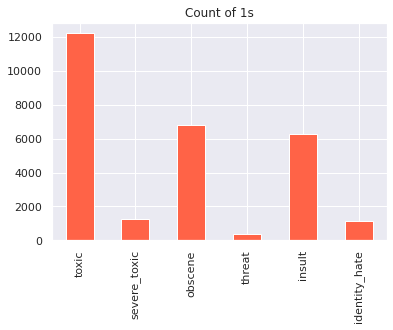

In [16]:
df_train[cols_label].sum().plot.bar(title='Count of 1s',color='tomato');

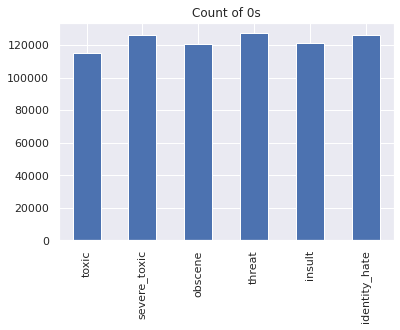

In [17]:
df_train[cols_label].eq(0).sum().plot.bar(title='Count of 0s');

# Data Processing: Training Data

## Shuffle data

In [18]:
# shuffle data
df_train = df_train.sample(frac=1,random_state=SEED).reset_index(drop=True)

## Lowercase

In [19]:
df_train[col_text] = df_train[col_text].str.lower()
df_test[col_text]  = df_test[col_text].str.lower()

## Tokenize using Bert Client

In [20]:
from bert_serving.client import BertClient

x_train = df_train[col_text].tolist()
x_test = df_test[col_text].tolist()

In [21]:
do_tokenize = False

if do_tokenize:

    !wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
    !unzip uncased_L-12_H-768_A-12.zip

    !nohup bert-serving-start -model_dir=./uncased_L-12_H-768_A-12 -max_seq_len 50 > out.file 2>&1 &

    # Start the BERT client
    bc = BertClient()
    x_train = bc.encode(x_train)
    x_test = bc.encode(x_test)

    # persist data
    np.savez_compressed('x_train.npz',x_train=x_train)
    np.savez_compressed('x_test.npz',x_test=x_test)

In [22]:
# print(bc.status)
# print()
# print(bc.server_status)

## Get the data

In [23]:
x_train = np.load('x_train.npz')['x_train']
x_test = np.load('x_test.npz')['x_test']

df_train.shape, x_train.shape

((127656, 8), (127656, 768))

In [24]:
!du -sh x_train.npz
!du -sh x_test.npz

347M	x_train.npz
87M	x_test.npz


# Data Preparation for Modelling

In [25]:
class_names = ['toxic', 'severe_toxic', 'obscene',
               'threat', 'insult', 'identity_hate']

x_train = x_train # tokenized array
x_test  = x_test # tokenized array

y_train = df_train[class_names].to_numpy()
y_test = df_test[class_names].to_numpy()

df_train.shape, np.array(x_train).shape

((127656, 8), (127656, 768))

# Modelling: keras

Focal loss
- https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy

multilabel focal loss
- https://github.com/maozezhong/focal_loss_multi_class
- https://github.com/vinayakkailas/BERT_multilabel_text_classification/blob/master/loss_util.py

In [26]:
import tensorflow as tf # bert server needs 1.x
import keras.backend as K

## Modellng: Keras

In [27]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return binary_focal_loss_fixed

In [28]:
N_FEATS = np.array(x_train).shape[-1]
NUM_CLASSES = 6
class MultiLabelClassifier:

    def __init__(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.Input(shape=(N_FEATS,)))
        self.model.add(tf.keras.layers.Dense(128, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(rate=0.2))
        self.model.add(tf.keras.layers.Dense(64, activation='relu'))
        self.model.add(tf.keras.layers.Dense(32, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(rate=0.8))
        self.model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid'))
        self.model.summary()

    def train(self, x_train, y_train, x_test, y_test,
              optimizer='nadam',
              loss=[tf.keras.losses.BinaryCrossentropy()],
              metrics=[tf.keras.metrics.AUC(name='auc')],
              batch_size=128, epochs=100):

        if metrics == 'auc':
            metrics = [tf.keras.metrics.AUC(name='auc')]

        # compile
        self.model.compile(optimizer, loss, metrics)

        history = self.model.fit(
            x_train, y_train,
            batch_size, epochs,
            validation_split=0.2,
            callbacks=[lrcurve.KerasLearningCurve()],
            verbose=0
            )
        results = self.model.evaluate(x_test, y_test, batch_size)
        ypreds = self.model.predict(x_test)
        for name, value in zip(self.model.metrics_names, results):
            print("%s: %.3f" % (name, value))
        return history, results, ypreds

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [29]:
%%time

# loss = [binary_focal_loss(gamma=3.0, alpha=0.5)] # this gave me f1-score = 0 for all
loss=[tf.keras.losses.BinaryCrossentropy()]

batch_size = 1024 # keep it large for imbalanced data
epochs = 40

classifier = MultiLabelClassifier()
history, results,yprobs = classifier.train(
    x_train,y_train,
    x_test,y_test,
    optimizer='adam',
    loss=loss,
    metrics='auc',
    batch_size=batch_size,
    epochs=epochs
    )

print(f"""
x_train: {len(x_train)}
x_test : {len(x_test)}
""")

# NOTE: The validation loss should be decreasing

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               98432     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 108,966
Trainable params: 108,966
Non-trainable params: 0
__________________________________________________

31915/31915 [==============================] - 0s 4us/sample - loss: 0.0775 - auc: 0.9508
loss: 0.078
auc: 0.951

x_train: 127656
x_test : 31915

CPU times: user 29.4 s, sys: 1.91 s, total: 31.4 s
Wall time: 26.9 s


# Model Evaluation

## Confusion Matrix

In [30]:
from sklearn import metrics as skmetrics
from sklearn.metrics import multilabel_confusion_matrix

print(yprobs[:5])
ypreds = (yprobs == yprobs.max(axis=1,keepdims=True)).astype(np.int8)

# if a row has all ONES, make it zero
# a row can't be all 1's
ypreds[np.all(ypreds,axis=1,keepdims=False)] = 0
print(ypreds[:5])

f1= skmetrics.f1_score(df_test[class_names], ypreds,average='micro')
acc = skmetrics.accuracy_score(df_test[class_names], ypreds)

print(f'F1-score (micro)  : {f1:.4f}')
print(f'Accuracy (overall): {acc:.4f}')

mcm = multilabel_confusion_matrix(df_test[class_names], ypreds)
# make sure second diagonal element is NOT ZERO!!
print(mcm)

[[6.9469213e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [2.9802322e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [1.8524528e-03 0.0000000e+00 1.1026859e-06 0.0000000e+00 5.9604645e-08
  0.0000000e+00]
 [2.5524199e-03 0.0000000e+00 2.2351742e-06 0.0000000e+00 3.2782555e-07
  0.0000000e+00]]
[[1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
F1-score (micro)  : 0.1784
Accuracy (overall): 0.1719
[[[ 4315 24508]
  [    4  3088]]

 [[31602     0]
  [  313     0]]

 [[30248     0]
  [ 1667     0]]

 [[31816     0]
  [   99     0]]

 [[30330     0]
  [ 1585     0]]

 [[31646     0]
  [  269     0]]]


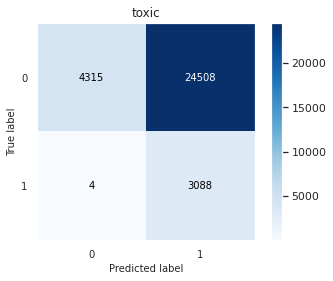

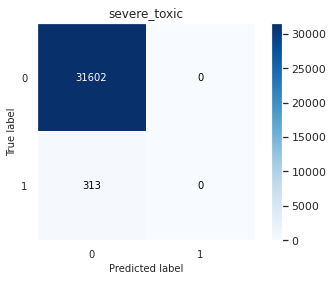

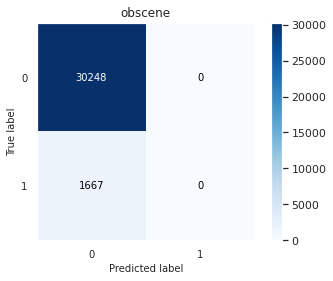

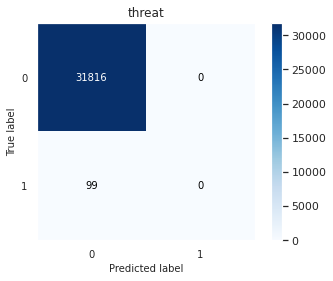

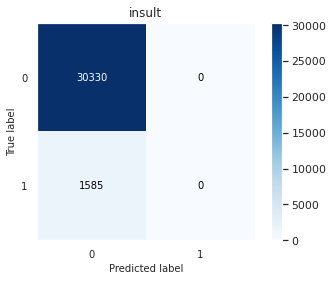

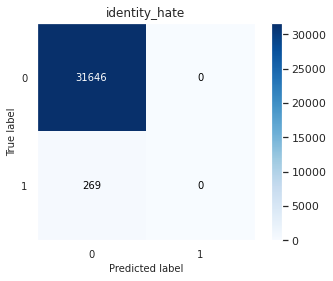

In [31]:
from scikitplot.metrics import plot_confusion_matrix

for i,class_name in enumerate(class_names):
    plot_confusion_matrix(df_test[class_name],ypreds[:,i],title=class_name)

## Classification Report

In [32]:
clf_report = skmetrics.classification_report(
    df_test[class_names], ypreds,
    target_names=class_names)

print(clf_report)

               precision    recall  f1-score   support

        toxic       0.11      1.00      0.20      3092
 severe_toxic       0.00      0.00      0.00       313
      obscene       0.00      0.00      0.00      1667
       threat       0.00      0.00      0.00        99
       insult       0.00      0.00      0.00      1585
identity_hate       0.00      0.00      0.00       269

    micro avg       0.11      0.44      0.18      7025
    macro avg       0.02      0.17      0.03      7025
 weighted avg       0.05      0.44      0.09      7025
  samples avg       0.10      0.06      0.07      7025



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Co-occurence Matrix

In [33]:
coo = np.array(df_test[class_names]).T.dot(np.array(ypreds))
df_coo = pd.DataFrame(coo, columns=class_names,index=class_names)
df_coo

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,3088,0,0,0,0,0
severe_toxic,313,0,0,0,0,0
obscene,1666,0,0,0,0,0
threat,99,0,0,0,0,0
insult,1583,0,0,0,0,0
identity_hate,269,0,0,0,0,0


In [34]:
df_coo2 = df_coo.copy()
df_coo2['Total'] = df_coo2.sum(axis=1)
df_coo2.loc[len(df_coo2),:] = df_coo2.sum(axis=0)
df_coo2.index = df_coo.index.tolist() + ['Total']
df_coo2 = df_coo2.astype(int)

# horizontal is true, vertical is predicted
df_coo2

,toxic,severe_toxic,obscene,threat,insult,identity_hate,Total
toxic,3088,0,0,0,0,0,3088
severe_toxic,313,0,0,0,0,0,313
obscene,1666,0,0,0,0,0,1666
threat,99,0,0,0,0,0,99
insult,1583,0,0,0,0,0,1583
identity_hate,269,0,0,0,0,0,269
Total,7018,0,0,0,0,0,7018


In [35]:
def highlight_diagf(dfx, color="khaki"):
    def highlight_diag(dfy):
        a = np.full(dfy.shape, "", dtype="<U24")
        np.fill_diagonal(a, f"background-color: {color}")
        df1 = pd.DataFrame(a, index=dfy.index, columns=dfy.columns)
        return df1

    return dfx.style.apply(highlight_diag, axis=None)

In [36]:
highlight_diagf(df_coo2)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,Total
toxic,3088,0,0,0,0,0,3088
severe_toxic,313,0,0,0,0,0,313
obscene,1666,0,0,0,0,0,1666
threat,99,0,0,0,0,0,99
insult,1583,0,0,0,0,0,1583
identity_hate,269,0,0,0,0,0,269
Total,7018,0,0,0,0,0,7018
